In [23]:
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import scipy.stats
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import re
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context("talk")
import datetime
# Plot settings
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['font.size'] = 12

# Load dataset


In [24]:
client = pd.read_csv("cliente_tabla.csv")
product = pd.read_csv("producto_tabla.csv")
town = pd.read_csv("town_state.csv")
sales = pd.read_csv("data.csv")

In [25]:
#Dimensions of the dataset
def shape():
    print("client = ",client.shape,"\n product = ",product.shape,"\n town = ",town.shape, "\n sales = ",sales.shape)

shape()

client =  (935362, 2) 
 product =  (2592, 2) 
 town =  (790, 3) 
 sales =  (462740, 11)


Preview of the datasets



In [26]:
# client.head(3)
# product.head(3)
# town.head(3)
# sales.head(3)

In [27]:
sales.info()
#product.info()
#town.info()
#client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462740 entries, 0 to 462739
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       462740 non-null  int64  
 1   Semana           462740 non-null  int64  
 2   Agencia_ID       462740 non-null  int64  
 3   Canal_ID         462740 non-null  int64  
 4   Ruta_SAK         462740 non-null  int64  
 5   Cliente_ID       462740 non-null  int64  
 6   Producto_ID      462740 non-null  int64  
 7   Venta_uni_hoy    462740 non-null  int64  
 8   Venta_hoy        462740 non-null  float64
 9   Dev_uni_proxima  462740 non-null  int64  
 10  Dev_proxima      462740 non-null  float64
dtypes: float64(2), int64(9)
memory usage: 38.8 MB


In [28]:
#town.describe()
sales.describe()
#product.describe()
#client.describe()

,Unnamed: 0,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima
count,462740.000000,462740.000000,462740.000000,462740.000000,462740.000000,4.627400e+05,462740.000000,462740.000000,462740.000000,462740.000000,462740.000000
mean,231369.500000,5.978612,3009.919469,2.587781,2058.055563,1.004012e+06,28723.140984,76.891412,848.496654,3.170869,24.699612
std,133581.676119,2.001538,5092.256670,1.858762,1443.241251,1.352308e+06,16638.288438,123.225466,1500.171309,367.797829,134.162629
min,0.000000,3.000000,1111.000000,1.000000,1.000000,6.500000e+01,72.000000,0.000000,0.000000,0.000000,0.000000
25%,115684.750000,4.000000,1142.000000,1.000000,1033.000000,1.484320e+05,6490.000000,9.000000,79.280000,0.000000,0.000000
50%,231369.500000,6.000000,1276.000000,2.000000,1634.000000,6.533780e+05,34210.000000,30.000000,319.040000,0.000000,0.000000
75%,347054.250000,8.000000,2229.000000,5.000000,3006.000000,1.128951e+06,43064.000000,98.000000,1018.600000,0.000000,0.000000
max,462739.000000,9.000000,25759.000000,11.000000,9921.000000,9.679244e+06,49996.000000,4228.000000,54247.000000,250000.000000,17400.000000


In [29]:
#Rename the columns in english
sales.rename(columns={"Unnamed: 0":"row","Semana":"week_number", "Agencia_ID":"sales_depot_id", "Canal_ID":"sales_channel_id","Ruta_SAK":"route_id", "Cliente_ID":"client_id", "NombreCliente":"client_name", "Producto_ID":"product_id", "NombreProducto":"product_name", "Venta_uni_hoy":"sales_unit", "Venta_hoy":"sales", "Dev_uni_proxima":"returns_unit", "Dev_proxima":"return" }, inplace = True)
sales.set_index("row", inplace=True)
client.rename(columns={"Cliente_ID":"client_id", "NombreCliente":"client_name"}, inplace=True)
product.rename(columns= {"Producto_ID":"product_id","NombreProducto":"product_name"}, inplace=True)
town.rename(columns={"Agencia_ID":"sales_depot_id"}, inplace=True)

In [30]:
#Double check of the columns' names
sales.head(1)

,week_number,sales_depot_id,sales_channel_id,route_id,client_id,product_id,sales_unit,sales,returns_unit,return
row,,,,,,,,,,
0,3,1111,1,1001,50827,73,6,127.92,0,0.0


# Part 1: Data cleaning 

In [31]:
client.head(3)

,client_id,client_name
0,0,SIN NOMBRE
1,1,OXXO XINANTECATL
2,2,SIN NOMBRE


We observe that the `client_name` column is noisy, there a some clients with multiple `client_id`. We will solve this problem by transforming all the noisy names into one single format into a new column called `encoded_name`
- First we lower the cases
- Then we strip the names
- Finally all the number with the same encoded name will be attributed the name of the first occurence
In this way, when we will merge with the sales dataset, different clients id of the same client will be attributed the same name as written in the database, we now can drop the duplicates


### Uniformize client_name ###

In [32]:
print(" Initially, the number of unique clients_names that we have is ",len(client.client_name.unique()),"\n If we strip the names, that yields to ", len(client.client_name.str.replace(" ","").unique()),"\n Putting them in lower case yield ",len(client.client_name.str.replace(" ","").str.lower().unique()))

 Initially, the number of unique clients_names that we have is  311155 
 If we strip the names, that yields to  305003 
 Putting them in lower case yield  304876


In [33]:
client["encoded_name"] = client.client_name.str.replace(" ","").str.lower()

In [34]:
bool = client.duplicated(subset = "encoded_name")
print("the number of duplicated client's names is ",sum(bool))
duplicates = client[bool]   #A dataframe of all the duplicates "encoded_name"

the number of duplicated client's names is  630486


In [35]:
duplicates['encoded_name'].value_counts()    #Count of duplicates

noidentificado           281669
lupita                     4862
mary                       3015
lapasadita                 2426
laventanita                2271
                          ...  
ensastiga                     1
guadalupeperezmaciel          1
medianaranja                  1
arturoortizavila              1
abarroteslavirgencita         1
Name: encoded_name, Length: 39287, dtype: int64

In [36]:
uniques = client.drop_duplicates(subset = "encoded_name", keep='first')     #A dataframe of all the unique "encoded_name" (first occurence)
uniques.reset_index(inplace=True)

In [37]:
#Create a mapping of encoded_name : [client_id , client_name] client name refer to the name of the first occurence of the client in the dataset 
dico = {}
for i in range(len(uniques)):
    dico[uniques.encoded_name.iloc[i]] = [uniques.client_id.iloc[i], uniques.client_name.iloc[i]]

In [38]:
# Attribute the first name in a new column the one of the first occurence
name = []
for i in range(len(client)):
    encoded_name = client.encoded_name.iloc[i]
    name.append(dico[encoded_name][1])
client["client_unique_name"] = name  

In [39]:
clean_client = client[["client_id","client_unique_name"]]

In [40]:
#Double check if we the names are uniform
len(clean_client.client_unique_name) == len(clean_client.client_unique_name.str.replace(" ","").str.lower())

True

In [41]:
#Now we delete the duplicates client_id
clean_client = clean_client.drop_duplicates(subset = "client_id")
clean_client.shape

(930500, 2)

We will now merge the data

In [42]:
#Add the client data
data_with_client = pd.merge(left = sales, right = clean_client, left_on="client_id", right_on="client_id", how='left')

#Add the product data
data_with_product = pd.merge(left = data_with_client, right = product, left_on="product_id", right_on="product_id", how='left')

#Add the town data
data = pd.merge(left = data_with_product, right = town, left_on="sales_depot_id", right_on="sales_depot_id", how='left')

data.shape

(462740, 14)

# Part 2: Exploratory Data Analysis

In this section, we will make a serie of exploratory visualizations and interpret them.
We will ensure to create pipelines for repeatability



Some assumptions:
- Demand = Sales
- Costs = return

In [43]:
print(" The number of unique depot is ",len(data.sales_depot_id.unique()),"\n The number of unique sales channel is ",len(data.sales_channel_id.unique()) \
      ,"\n The number of unique route is ",len(data.route_id.unique()),"\n The number of unique client is ",len(data.client_id.unique())\
       ,"\n The number of unique product is ",len(data.product_id.unique()),"\n The number of unique states is ",len(data.State.unique()))

 The number of unique depot is  220 
 The number of unique sales channel is  7 
 The number of unique route is  1001 
 The number of unique client is  530 
 The number of unique product is  954 
 The number of unique states is  33


In [44]:
#Create the profit per transaction column
data["profit"] = data['sales'] - data['return']

Create KPI of the business

In [45]:
total_revenue = round(sum(data.sales))
total_profit = round(sum(data.profit))
profitability = round((total_profit / total_revenue)*100)  # share of profit over the revenue

print("The total revenue of the company is ",total_revenue," and the total profit is ",total_profit," which yields a profitability of ",profitability,"%")

The total revenue of the company is  392633342  and the total profit is  381203843  which yields a profitability of  97 %


In [46]:
# Funtion to Add column to grouped dataset 
def add_return_on_sale(data):
    data["return_on_sale"] = round((data["profit"]/data["sales"])*100, 2)

def add_return_rate(data):
    data["return_rate"] = round((data.returns_unit/(data.returns_unit + data.sales_unit))*100, 2)
    
def add_share_revenue(data):
    data["share_revenue"] = round((data.sales/total_revenue)*100, 3)
    


## Study channel ##

In [47]:
grouped = data.groupby("sales_channel_id")
channel = grouped.sum()
add_return_rate(channel)
add_return_on_sale(channel)
add_share_revenue(channel)
#channel          #cumulated results per channel

In [48]:
channel[["return_rate", "return_on_sale", "share_revenue"]]

,return_rate,return_on_sale,share_revenue
sales_channel_id,,,
1,0.45,99.54,8.088
2,1.43,98.62,47.785
4,0.29,99.64,0.075
5,5.86,94.94,43.756
7,0.01,99.99,0.144
8,0.00,100.00,0.046
11,0.42,99.56,0.105


Channel 2,5 and 1 are the most prolific channels since they generate respectively **48%**, **44%** and **8%** of the revenue. However we note on channel 5 the highest percent of return over all the channels

In [49]:
#We separate the categories in 2
big_channel = channel[channel.index.isin([1,2,5])]
small_channel = channel[channel.index.isin([4,7,8,11])]

In [50]:
def plot_channel(data): 
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
    sns.barplot(x=data.index, y="sales", data=data, ax=ax, color = "m")
    sns.barplot(x=data.index, y="profit", data=data, ax=ax, color= '#EE6666')


    ax.set_title('Sales and profit per channel')
    ax.set_ylabel("sales")
    ax.set_xlabel("Channel")
#     ax.legend()
    plt.tight_layout()

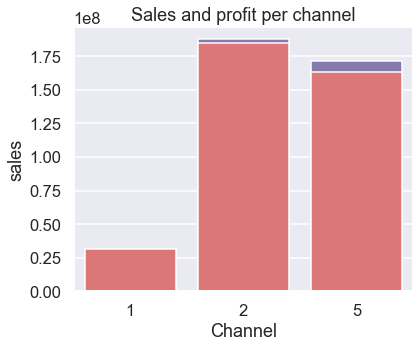

In [51]:
plot_channel(big_channel)

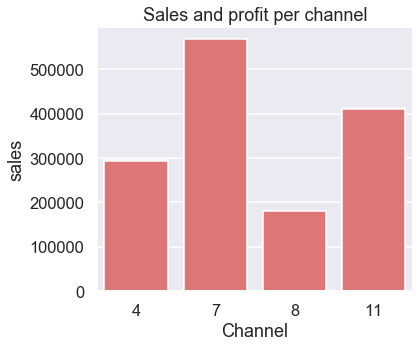

In [52]:
plot_channel(small_channel)

The "small channel" generate 1000 less revenue than the big ones however they a profitable, they can open new markets. The most prolific one is channel 7

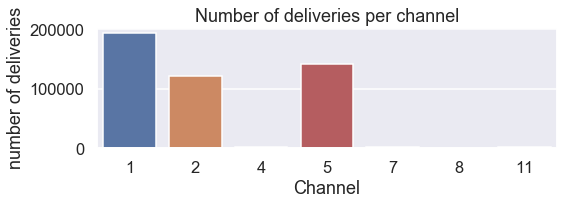

In [53]:
fig, ax = plt.subplots(figsize=(8,3))
sns.countplot(x='sales_channel_id', data=data, ax=ax)
ax.set_title('Number of deliveries per channel')
ax.set_ylabel("number of deliveries")
ax.set_xlabel("Channel")

plt.tight_layout()

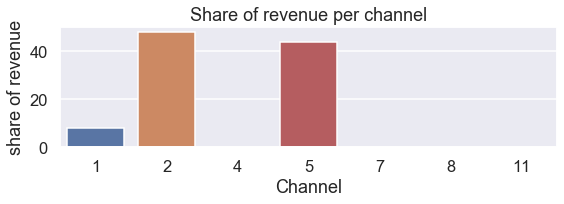

In [54]:
fig, ax = plt.subplots(figsize=(8,3))
sns.barplot(x= channel.index, y='share_revenue', data=channel, ax=ax)
ax.set_title('Share of revenue per channel')
ax.set_ylabel("share of revenue")
ax.set_xlabel("Channel")

plt.tight_layout()

> **Conclusion**

There are 3 majors channels of distribution that generate more than 99% of the revenue of the company. Precisely 1,2 and 5. There are some improvements to be made on channel 5 given the fact that is has the lowest rentability.
<br>If the problem is about the `expiration of the product`, we can modify our channel to **give longer lifespan** to our products.
<br>According to **Eric Kayser (fourth generation baker in France)**, the best way to store bread (particularly the artisanal variety) is **to wrap it in a dish towel or paper bag and keep it in a dry place**. All breads, from boules to sandwich loaves, should be stored the same way. However, Kayser says, **the bigger the bread, the longer the shelf life**: "A baguette, for example, will be good if you eat it quickly, within about eight hours from the time it was baked. But some of our customers say they can keep our Tourte de Meule for 10 days." 
Thus, we should prioritize on this channel products that can be stored in this way.


In [55]:
# Here is a link of the interview of Eric Kayser
#https://www.tastingtable.com/dine/national/how-to-keep-bread-fresh-how-to-freeze-bread

## Study return ##

In [56]:
grouped = data.groupby("week_number")
week = grouped.sum()
add_return_rate(week)
add_return_on_sale(week)
week          #cumulated results per week 

,sales_depot_id,sales_channel_id,route_id,client_id,product_id,sales_unit,sales,returns_unit,return,profit,return_rate,return_on_sale
week_number,,,,,,,,,,,,
3,203349648,174257,137433463,67825817492,1932053124,5141919,5.632870e+07,178162,1633115.60,5.469558e+07,3.35,97.10
4,199166446,173532,139556705,67603806984,1927859495,5373205,5.918766e+07,177559,1665212.76,5.752245e+07,3.20,97.19
5,196908410,170934,138459615,67230645116,1907923120,5155586,5.680911e+07,162281,1574994.76,5.523411e+07,3.05,97.23
6,199843943,169377,133785425,65502652857,1872833431,4830435,5.410710e+07,176552,1638710.09,5.246839e+07,3.53,96.97
7,204350639,170033,134473944,66343010832,1888299452,5031443,5.544858e+07,168272,1599350.91,5.384923e+07,3.24,97.12
8,197374016,170782,135279049,65739535465,1893475909,4996433,5.529200e+07,186235,1738505.24,5.355350e+07,3.59,96.86
9,191817033,168555,133356430,64350996981,1868901728,5051711,5.546020e+07,418227,1579608.93,5.388059e+07,7.65,97.15


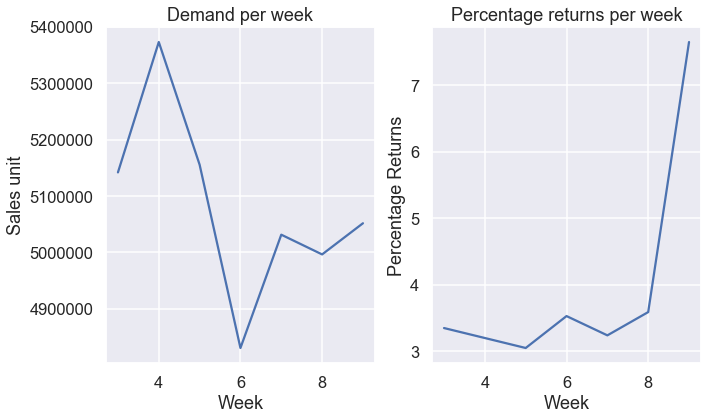

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
sns.lineplot(x=week.index, y="sales_unit", data=week, ax=ax[0])
sns.lineplot(x=week.index, y="return_rate", data=week, ax=ax[1])
ax[0].set_title('Demand per week')
ax[0].set_ylabel("Sales unit")
ax[0].set_xlabel("Week")

ax[1].set_title('Percentage returns per week')
ax[1].set_ylabel("Percentage Returns")
ax[1].set_xlabel("Week")
plt.style.context('bmh')
plt.tight_layout()

We can take the value 4% return as an indicator of the limit of the acceptable return rate

> **Conclusion**

We oberve that after the first few weeks, our demand become stable. Returns have the same trend despite a spike at week 9
We can thus set **4%** as a fair indicator of green in terms of returns


### Study the clients ###

No we can never blacklist a client, we have to adjust our supply to limit the returns

In [82]:
grouped = data.groupby("client_unique_name")
clients = grouped.sum()
clients.drop("NO IDENTIFICADO", axis=0, inplace = True)
add_return_on_sale(clients)
add_return_rate(clients)
add_share_revenue(clients)
clients.sort_values(["return_rate"], ascending=False, inplace=True)

In [83]:
a = clients[clients["return"] > 100000]
a

,week_number,sales_depot_id,sales_channel_id,route_id,client_id,product_id,sales_unit,sales,returns_unit,return,profit,return_on_sale,return_rate,share_revenue
client_unique_name,,,,,,,,,,,,,,
SOMAKI DE MEXICO 8644,7451,1577136,6180,3720057,773106876,27479259,3527,2.901724e+04,11932,104733.72,-7.571648e+04,-260.94,77.18,0.007
CHIHUAHUA REMISION,10043,6607369,8100,4870495,1057680180,55473452,6118,4.858820e+04,17752,149645.14,-1.010569e+05,-207.99,74.37,0.012
SAN LUIS POTOSI REMISION,6505,2142174,5415,3254939,707261814,31821549,6704,5.252511e+04,18938,160844.65,-1.083195e+05,-206.22,73.86,0.013
COMODIN R 4302 AG 2216 CAMPECHE BS,3376,1297152,1152,868893,589821696,22594605,8333,1.254591e+05,8678,134440.89,-8.981790e+03,-7.16,51.01,0.032
JALISCO REMISION,15692,5021130,13110,7880377,1711772700,78051566,490617,4.018867e+06,59664,495570.18,3.523296e+06,87.67,10.84,1.024
PUEBLA REMISION,744333,254950746,620295,373304975,81057421302,3670494633,18650001,1.546623e+08,1131794,7367474.15,1.472948e+08,95.24,5.72,39.391
QUERETARO DE ARTEAGA REMISION,31691,6420260,26530,15961275,3465024934,160330573,909671,7.697623e+06,16642,143066.78,7.554557e+06,98.14,1.80,1.961


In [84]:
premium_clients = list(a.index)
print(premium_clients)

['SOMAKI DE MEXICO 8644', 'CHIHUAHUA REMISION', 'SAN LUIS POTOSI REMISION', 'COMODIN R 4302 AG 2216 CAMPECHE BS', 'JALISCO REMISION', 'PUEBLA REMISION', 'QUERETARO DE ARTEAGA REMISION']


> **Conclusion**

The variable `premium_clients` is a list of our best suppliers given the number of units sold we can assume a good relationship with the customer. Thus, a good solution to edge from the risk of returns is **to negotiate contracts of constant deliveries to avoid returns**.
<br> For the other clients and deliveries in the further lines we will try to find an estimate of the distribution of the demand 

### Study the products ###

We create here the variable `demand` which is for each product the number of sales per week 

In [61]:
def demand(data, first_week, last_week):   #Input the data, the number of the first week and the number of the last week 
    weeks = list(range(first_week,last_week+1))
    copy = data.copy()
    for i in weeks:
        week = "week_"+str(i)
        copy.loc[copy['week_number'] == i, week] =  copy["sales_unit"]  #Number of sales corresponding to a given week 
    copy.fillna(0, inplace=True)  #filling the blanks of the wrong week on the right column
    grouped = copy.groupby("product_name")
    copy = grouped.sum()
    copy = copy.drop(["week_number", "sales_depot_id", "sales_channel_id", "route_id", "client_id", "product_id", "sales_unit", "sales",\
               "returns_unit", "return", "profit"], axis=1) 
    return copy

In [62]:
demand = demand(data, 3,9)

In [63]:
trans = demand.T
trans.head(2)

product_name,7 Granos 680g MTA ORO 43160,7 Granos 680g ORO 714,ActiFresh Menta 6p 27g RIC 35631,ActiFresh Yerbabuena 6p 27g RIC 35632,Agua Ciel Jamaica 12p 600ml CC 30378,Agua Ciel Jamaica 24p 600ml CC 30379,Agua Ciel Jamaica 600ml CC 49735,Agua Ciel Limon 12p 600ml CC 30380,Agua Ciel Limon 24p 600ml CC 30381,Agua Ciel Limon 600ml CC 49736,...,Twinkies Vainilla 2p 76g MTB MLA 36275,Wonder 100pct Ajonjoli 680g SP MTA WON 43359,Wonder 100pct Ajonjoli 680g SP WON 4468,Wonder 100pct con Ajonjoli 567g MTA WON 35145,Wonder 100pct con Ajonjoli 567g WON 35144,Wonder 100pct gde 680g SP MTA WON 43339,Wonder 100pct grande 567g MTA WON 35148,Wonder 100pct grande 567g WON 35147,Wonder 100pct mediano 475g MTA WON 43131,Wonder 100pct mediano 475g WON 106
week_3,8207.0,76.0,4511.0,4120.0,201.0,24.0,5737.0,215.0,34.0,5694.0,...,23.0,0.0,0.0,54202.0,2618.0,0.0,9911.0,669.0,2414.0,210.0
week_4,8769.0,95.0,4324.0,4715.0,135.0,24.0,5448.0,159.0,36.0,5082.0,...,0.0,0.0,0.0,58159.0,2722.0,0.0,10587.0,798.0,1875.0,197.0


In [64]:
def plot_demand(product_name):
    sns.distplot(trans[product_name], hist=True, kde=True, 
                 bins=int(7), color = 'darkblue', 
                 hist_kws={'edgecolor':'black'},
                 kde_kws={'linewidth': 4})

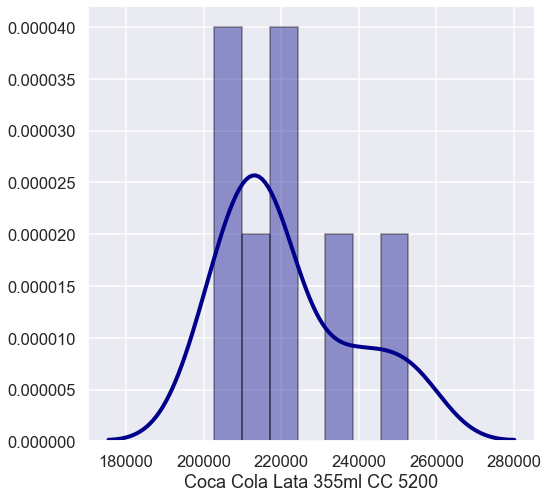

In [65]:
plot_demand("Coca Cola Lata 355ml CC 5200")

## Build a Descriptive model ##
We would like to build a model to approximate the distribution of the sale, which is assimilated to the demand of the product. 
1. Use the **Chi squared test**, we will select the distribution that gives the best estimates of the demand. 
2. Simulate 7 days with different policies of production
3. Choose the one that yields the highest increase in expected profit.

In [66]:
grouped = data.groupby("product_name")
pro = grouped.sum()
add_return_on_sale(pro)
add_return_rate(pro)
add_share_revenue(pro)
pro.sort_values(["return"], ascending=False, inplace = True)
pro.head(4)

,week_number,sales_depot_id,sales_channel_id,route_id,client_id,product_id,sales_unit,sales,returns_unit,return,profit,return_on_sale,return_rate,share_revenue
product_name,,,,,,,,,,,,,,
Mantecadas Vainilla 4p 125g BIM 1240,26139,12289237,13970,9747381,4367687376,5433680,599669,6409815.27,52735,585323.47,5824491.80,90.87,8.08,1.633
Donas Azucar 4p 105g BIM 1250,26910,12235193,14633,10158629,4428804378,5636250,886962,7979454.26,45951,425047.34,7554406.92,94.67,4.93,2.032
Coca Cola Lata 355ml CC 5200,13239,5127566,11040,6640676,1476828636,11481600,1550394,13626890.30,33825,294855.85,13332034.45,97.84,2.14,3.471
Kiyakis 25pz de 50g BAR 45449,17310,5948413,14455,8698132,1922447937,131393059,379333,2817255.97,30028,223319.96,2593936.01,92.07,7.34,0.718


We sample the products with the highest returns in the variable `products_high_return`

In [67]:
products_high_return = list(pro.iloc[:5].index)
products_high_return

['Mantecadas Vainilla 4p 125g BIM 1240',
 'Donas Azucar 4p 105g BIM 1250',
 'Coca Cola Lata 355ml CC 5200',
 'Kiyakis 25pz de 50g BAR 45449',
 'Duo Nito 124g SP BIM 40985']

### Create a pipeline to find the distribution of demand for a product ###

In [68]:
#List of the distributions that we will use for our tests
dist_names = ["weibull_min",'norm','weibull_max','beta', 'invgauss','uniform','gamma','expon', 'lognorm','pearson3','triang']

### Chi square test ###

In [69]:
def find_distribution(data, product: str, dist_names: list): #Here we will run a Chi square test to find the distribution with the best fit to demand 
    trans = data 
    
    y = trans[product].values  # Extract the values of the serie of demand per week
    x = np.arange(len(y))
    size = len(y)  
    
    sc=StandardScaler()   #Standardize the data
    yy = y.reshape (-1,1)
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    del yy
    
    #Borrowed from https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/

    # Set up empty lists to stroe results
    chi_square = []
    p_values = []

    # Set up 7 bins for chi-square test
    # Observed data will be approximately evenly distrubuted aross all bins
    percentile_bins = np.linspace(0,100,7)
    percentile_cutoffs = np.percentile(y_std, percentile_bins)
    observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
    cum_observed_frequency = np.cumsum(observed_frequency)

    # Loop through candidate distributions

    for distribution in dist_names:
        # Set up distribution and get fitted distribution parameters
        dist = getattr(scipy.stats, distribution)
        param = dist.fit(y_std)

        # Obtain the KS test P statistic, round it to 5 decimal places
        p = scipy.stats.kstest(y_std, distribution, args=param)[1]
        p = np.around(p, 5)
        p_values.append(p)    

        # Get expected counts in percentile bins
        # This is based on a 'cumulative distrubution function' (cdf)
        cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                              scale=param[-1])
        expected_frequency = []
        for bin in range(len(percentile_bins)-1):
            expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
            expected_frequency.append(expected_cdf_area)

        # calculate chi-squared
        expected_frequency = np.array(expected_frequency) * size
        cum_expected_frequency = np.cumsum(expected_frequency)
        ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
        chi_square.append(ss)

    # Collate results and sort by goodness of fit (best at top)

    results = pd.DataFrame()
    results['Distribution'] = dist_names
    results['chi_square'] = chi_square
    results['p_value'] = p_values
    results.sort_values(['chi_square'], inplace=True)
    
    
        # Get the top three distributions from the previous phase
    number_distributions_to_plot = 3
    dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

    # Create an empty list to stroe fitted distribution parameters
    parameters = []

    # Loop through the distributions ot get line fit and paraemters

    for dist_name in dist_names:
        # Set up distribution and store distribution paraemters
        dist = getattr(scipy.stats, dist_name)
        param = dist.fit(y)
        parameters.append(param)
    

    # Store distribution paraemters in a dataframe (this could also be saved)
    dist_parameters = pd.DataFrame()
    dist_parameters['Distribution'] = (
            results['Distribution'].iloc[0:number_distributions_to_plot])
    dist_parameters['Distribution parameters'] = parameters
    
    # Report results

    print ('\nDistributions sorted by goodness of fit:')
    print ('----------------------------------------')
    print (results)
    
    #-----------------------if statement for outputs--------------------------------------------------------------------------------
    
    a = dist_parameters["Distribution parameters"].iloc[0] 
    
    if len(a) == 3:
        s, mu, scale = dist_parameters["Distribution parameters"].iloc[0]    #(shape is σ , loc is µ, and scale is α)
    
        dist = results["Distribution"].iloc[0]
    
        print("The best approximative distribution for the product ",product," is ", results["Distribution"].iloc[0], "\nThe parameters are shape = ",s,"mu = ",mu,"scale = ",scale)
        
        return dist, s, mu, scale          #Return s, mu and scale of the chosen distribution 
    
    if len(a) == 1:
        s = dist_parameters["Distribution parameters"].iloc[0]
        
        dist = results["Distribution"].iloc[0]
        
        print("The best approximative distribution for the product ",product," is ", results["Distribution"].iloc[0], "\nThe parameters are shape = ",s)
        
        return dist, s 
    
    if len(a) == 2:
        s, mu = dist_parameters["Distribution parameters"].iloc[0]
        
        dist = results["Distribution"].iloc[0]
        
        print("The best approximative distribution for the product ",product," is ", results["Distribution"].iloc[0], "\nThe parameters are shape = ",s,"mu = ",mu)
        
        return dist, s, mu
    
    if len(a) == 4:
        s = dist_parameters["Distribution parameters"].iloc[0]
        
        dist = results["Distribution"].iloc[0]
        
        print("The best approximative distribution for the product ",product," is ", results["Distribution"].iloc[0], "\nThe parameters are shape = ",s)
        
        return dist, s 
    
    

**The best estimation is the one with the lowest chi square value**

In [70]:
#Test for one product
distribution_name, s, mu, scale =  find_distribution(trans, "Coca Cola Lata 355ml CC 5200", dist_names)


Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  chi_square  p_value
8       lognorm    0.515762  0.99666
4      invgauss    0.523185  0.99584
0   weibull_min    0.888333  0.84719
7         expon    1.276397  0.98756
5       uniform    1.537709  0.16078
1          norm    2.058477  0.52888
3          beta    2.940897  0.94652
10       triang    5.088603  0.10588
9      pearson3    5.418374  0.57833
6         gamma    6.342022  0.37949
2   weibull_max   14.704052  0.10525
The best approximative distribution for the product  Coca Cola Lata 355ml CC 5200  is  lognorm 
The parameters are shape =  7.238386243700922 mu =  202770.99999999997 scale =  2.5981185460062726


### Generate a sample ###

In [71]:
def generate_lognormal_samples(mean, stdev, n=1):
 
    # Calculate mu and sigma of underlying lognormal distribution
    phi = (stdev ** 2 + mean ** 2) ** 0.5
    mu = np.log(mean ** 2 / phi)
    sigma = (np.log(phi ** 2 / mean ** 2)) ** 0.5
    
    # Generate lognormal population
    generated_pop = np.random.lognormal(mu, sigma , n)
    
    # Convert single sample (if n=1) to a float, otherwise leave as array
    generated_pop = \
        generated_pop[0] if len(generated_pop) == 1 else generated_pop
    
    return generated_pop

In [81]:
generate_lognormal_samples(202771, 7.238)

202771.9775426681

Confidence interval

In [72]:
np.random.seed(1)
l = []
for i in range(10000):     #95% confidence interval of the mean 
    demand = generate_lognormal_samples(mu, s, 7)
    l.append(np.mean(demand))
ci = [int(np.mean(l)-1.96*np.std(l)) ,  int(np.mean(l)+1.96*np.std(l))]
ci

[202765, 202776]

### Simulation of differents policies ###
$$Production = x * Avg(Demand)$$                                  
<br>We will assume that `Demand ~ logN(µ,s)`

<br> **Policy evaluation:** We run 100 simulations of 7 weeks of demand and production according to the chosen policy, then we compute the expected profit and its standard deviation

In [73]:
coef = [0.8,0.9,0.95,1,1.05,1.1,1.2]

In [74]:
def experiment_policies(product: str, coef: list, function, mu, s):  #Function is the generative of the assumed distribution samples
    np.random.seed(1)
    exp = {}
    
    price_unit = pro.loc[product,"sales"] / pro.loc[product,"sales_unit"]
    total_profit = pro.loc[product,"profit"]
    
    for x in coef:
        l = []
        for i in range(100):
            production = np.ones(7) * int(mu) * x        #We produce x times the expectation of our assume demand
            demand = function(mu, s, 7)          #Simulate the demand given the Lognormal distribution
            sales = demand * price_unit           #Sales = demand * unit p
            returns = production - demand         #returns = prod - demand
            loss = returns * price_unit            #loss = returns * unit price
            profit = sales - loss               
            l.append(np.sum(profit))             #Each simulation we record the average profit over the 7 days 
        exp[str(x)+"D"] = [int(np.mean(l)),int(np.std(l))]          #The mean of those average over 100 simulations will be the expectation of profit
        
    
    
    experiment = pd.DataFrame(exp).T
    experiment.rename(columns = {0:"Expectation of profit", 1:"Standard Deviation"}, inplace= True)
    
    experiment["Gain of the strategy"] = experiment["Expectation of profit"] - total_profit          #Gain is the expected profit - actual total profit
    
    experiment.sort_values("Gain of the strategy", ascending = False, inplace = True)        #Sort to have the strategy with highest profit 
    
    return experiment

In [75]:
experiment_policies("Coca Cola Lata 355ml CC 5200", coef, generate_lognormal_samples, 202771, 7.24)

,Expectation of profit,Standard Deviation,Gain of the strategy
0.8D,14970663,352,1638628.55
0.9D,13723101,333,391066.55
0.95D,13099294,361,-232740.45
1D,12475510,316,-856524.45
1.05D,11851750,352,-1480284.45
1.1D,11227965,307,-2104069.45
1.2D,9980487,336,-3351547.45


> **Observation**

Below we have the distribution of products with the highest number of returns. We observe that **LogNorm** appears to be a pretty good assumption of distribution of demand for many products. For sake of simplicity, we find the best policy under the assumption of lognormal distribution for all those `products_high_return` 

In [76]:
for prod in products_high_return:
    find_distribution(trans, prod, dist_names)


Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  chi_square  p_value
4      invgauss    0.996269  0.65649
10       triang    1.177191  0.36728
6         gamma    1.187001  0.65366
8       lognorm    1.206686  0.65160
1          norm    1.221802  0.65531
5       uniform    1.654345  0.30433
3          beta    1.947518  0.89561
7         expon    2.359511  0.81213
9      pearson3    5.666591  0.67373
0   weibull_min    8.525177  0.38867
2   weibull_max   11.416248  0.27817
The best approximative distribution for the product  Mantecadas Vainilla 4p 125g BIM 1240  is  invgauss 
The parameters are shape =  10423.151287892888 mu =  75824.66763117068 scale =  3353.3722730199647

Distributions sorted by goodness of fit:
----------------------------------------
   Distribution  chi_square  p_value
8       lognorm    0.377455  0.99802
4      invgauss    0.411668  0.99778
5       uniform    0.449562  0.82594
1          norm    1.187531  0.97159
7

In [77]:
# We will just double check the mean proposed by those distributions match with the values that we had each of the 7 weeks 
trans[products_high_return]

product_name,Mantecadas Vainilla 4p 125g BIM 1240,Donas Azucar 4p 105g BIM 1250,Coca Cola Lata 355ml CC 5200,Kiyakis 25pz de 50g BAR 45449,Duo Nito 124g SP BIM 40985
week_3,93163.0,125364.0,218516.0,55138.0,82402.0
week_4,92335.0,132167.0,214151.0,56043.0,81136.0
week_5,91767.0,134922.0,207568.0,55383.0,85852.0
week_6,81988.0,122872.0,202771.0,51014.0,85398.0
week_7,84932.0,127710.0,217207.0,53921.0,94767.0
week_8,78895.0,123362.0,237405.0,52364.0,89358.0
week_9,76589.0,120565.0,252776.0,55470.0,90903.0


In [78]:
def policies(products_high_return):  #This fucntion output the policy that yields the highest expected profits over a simulation of seven days  
    index = []
    gain = []
    production = []
    policy = {}
    for prod in products_high_return:          #For each product I experiment different policies and output the best one
        
        y = trans[prod].values
        dist = getattr(scipy.stats, "lognorm")
        s, mu, _ = dist.fit(y) 
            
        a = experiment_policies(prod, coef, generate_lognormal_samples, mu, s)       
        index.append(prod)
        gain.append(a.iloc[0][2])
        production.append(a.index[0])
    policy = {"Gain of the strategy": gain, "Production policy": production}
    data = pd.DataFrame(policy, index = index)
    return data 

In [79]:
results = policies(products_high_return)
results

,Gain of the strategy,Production policy
Mantecadas Vainilla 4p 125g BIM 1240,1052314.20,0.8D
Donas Azucar 4p 105g BIM 1250,1556743.08,0.8D
Coca Cola Lata 355ml CC 5200,1638677.55,0.8D
Kiyakis 25pz de 50g BAR 45449,588681.99,0.8D
Duo Nito 124g SP BIM 40985,875456.44,0.8D


In [80]:
Benefits = results["Gain of the strategy"].sum()
print("Using this strategy the past 7 days we would have won on average ",int(Benefits),"pesos")

Using this strategy the past 7 days we would have won on average  5711873 pesos


# > **Conclusion** #

The main takeaways of this work can be summarized in the following points:
- There are 3 main important channels in terms of revenue generated **2, 5 and 1**. Channel 5 is the one with the highest rate of return so we ought to **prioritize on this channel deliveries which may be kept in the above-mentioned manner** in order to extend the period of validity of bread
- Regarding the previous performances in term of rate of return, we can set **no more than 4% as a weekly cap**
- We have also identified a group of **premium clients** that we can negociate contracts to deliver fixed commands on a weekly basis, given the history of trust that we have built to avoid returns
- We have **proposed, evaluated and simulated the demand** of 5 top products with the highest returns, assuming a **lognormal distribution**  

<br> With more data, we will be able to evaluate the actual performances of these models in real life and readjust accordingly. Also, it could be  interesting to try forecasting the demand with more weeks of data, or simply daily data using time series 

**Thank you !!!**